# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

# Question 1: Reading

1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).

The problem is about city scale 3D recounstruction. Current methods solve this problem on data from a structured source. This paper aims to reconstruct a city from unstructured photo collections like imgaes from the web. These photos have high variability making them hard to work with for SfM but they also capture a lot of information about the world. The reconstructions generated improve over time and 

pipeline : pre-processing ---> image matching ---> geometric estimation


2. How is this task different from a SLAM problem?

In SLAM we are trying to build a map of of the environment to be able to navigate through it. It builds a map that shows the current state of the environment while here we are trying to generate a 3D model of the city , it will not incorporate information which is changing like traffic or other things while this information is crucial for SLAM. In this task we will only have information (or structures) that are largely stationary.

# Question 2: Code!

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from http://grail.cs.washington.edu/projects/bal/ for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [1]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d
import util

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


First download the data file:

In [6]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "dubrovnik/"
FILE_NAME = "problem-16-22106-pre.txt.bz2"

URL = BASE_URL + DATASET_NAME + FILE_NAME

In [7]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [8]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [153]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)
print(camera_indices[::2].shape)
print(camera_params[camera_indices[::2]].shape)
print(point_indices)

(41859,)
(41859, 9)
[    0     0     0 ... 22104 22105 22105]


In [86]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (16, 9);
points_3d: (22106, 3);
camera_indices: (83718,); 
point_indices: (83718,); 
points_2d: (83718, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

# Visualise Point Cloud

Visualise `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [14]:
util.visualize_pointclouds([points_3d.T])

# Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [285]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]
n = n_cameras*camera_params.shape[1]
m = n_cameras*n_points

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 16
n_points: 22106
Total number of parameters to estimate: 144
Total number of residuals: 353696


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [76]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
![radial_distortion_1.png](../misc/radial_distortion_1.png) 
![radial_distortion_2.png](../misc/radial_distortion_2.png)

In [350]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    
    #############################
    #
    # TO DO : Implement this function based on the information mentioned above.
    #
    #############################
    
    points = rotate(points,camera_params[:,:3]) + camera_params[:,3:6]
    
    p = np.zeros((camera_params.shape[0],2))
    
    q = -(points/points[:,2].reshape(points.shape[0],1))[:,:-1]

    qn = (q[:,0]*q[:,0] + q[:,1]*q[:,1]).reshape(camera_params.shape[0],1)
    
    f = camera_params[:,6].reshape(camera_params.shape[0],1)
    
    k1 = camera_params[:,7].reshape(camera_params.shape[0],1)
    
    k2 = camera_params[:,8].reshape(camera_params.shape[0],1)

    return (f*( 1 + k1*qn + k2*qn*qn )*q)

In [351]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](../misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](../misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of datastructures that are meant for such a usecase - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [352]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [361]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):

    M = np.unique(camera_indices).shape[0]
    N = n_points
    
    m = point_indices.shape[0]*2
    n = 9*M + 3*N
    
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A

### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [362]:
%matplotlib inline
import matplotlib.pyplot as plt

In [363]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [364]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

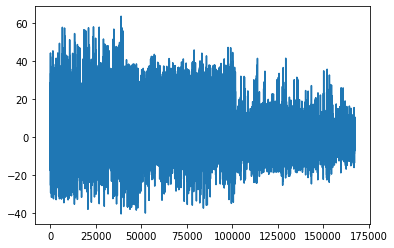

In [365]:
plt.plot(f0)

In [366]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

(167436, 66462) 16 22106


### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

In [367]:
import time
from scipy.optimize import least_squares

In [368]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1857e+06                                    3.53e+07    
       1              2         2.7977e+06      1.39e+06       2.42e+02       1.62e+07    
       2              5         2.7426e+06      5.51e+04       8.65e+00       1.27e+07    
       3             14         2.7426e+06      0.00e+00       0.00e+00       1.27e+07    
`xtol` termination condition is satisfied.
Function evaluations 14, initial cost 4.1857e+06, final cost 2.7426e+06, first-order optimality 1.27e+07.


In [369]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [370]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
o3d.visualization.draw_geometries([pcd])

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [371]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 23 seconds


Now let's plot residuals at the found solution:

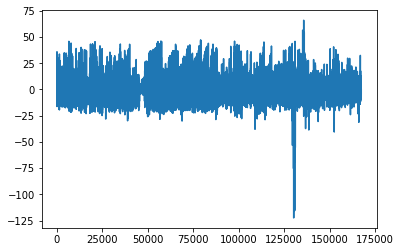

In [372]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Theory

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: The data is collected by taking a series of images of same object from different locations using the same camera. Then on two photos in a row, we apply SIFT or ORB to extract feature points. Then we can use 8 point algorithm to find Essential and Fundamental matrices (to scale), which are further divided into R and T matrices (the rotation and translation between the two images). From this we triangulate back to 3D world while doing this, it is known which image the points being backprojected came from, which is exactly the information stored in camera_ind.
    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: initial estimate of the 3D points is generated by triangulating and backprojecting the 2D points from the images because of how they are generated, it can be easily tracked which 3D point was generated by (and hence corresponds to) which 2D point. This can be done by assigning an index to each 2D point and labelling each 3D point with the same index.
    
    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: We need a 3x3 matrix to represent rotation but using rodriquez allows us to represent rotation using only 3 parameters. To represent rotation we need axis of rotation and angle of rotation. If we represent axis of rotation using a unit vector then we multiply the unit vector with the angle of rotation and the result will be 3x1 vector of the form $\theta n$. From this the magnitude will be angle of rotation and on dividing the vector with magnitude we get the unit vector representing axis of rotation.

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: Translation vector lies in the camera frame so before applying the translation it the point should be rotated into camera frame , we cannot directly add two vectors in different frames
        
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian: number of rows in a jacobian will be the number of residuals. Here , that is same as the twice the number of 2D points. In class, we assumed that each of the  N points is visible in all M images, hence giving us MN 2D points which is not the case here so we use camera_indices.size 2D points. 
    
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: 12 or 9 correspond to number of camera parameters. In class we represented rotation using 3x3 patrix , translation 3x1 vector , K - 3x3 matrix , thus P = K[R|t] was 3x4 matrix and had 12 parameters. However , here we have only 9 parameters , axis angle rotation - 3 , translation - 3 , focal length - 1 , distortion - 2.
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters:   
        In class : 12(n_cameras) + 3(n_points)
 
        Here : 9(n_cameras) + 3(n_points)
        
        In class we optimized over all intrinsic and extrinsic parameters (all parameters in the 3x4 P matrix) , but here we are optimizing seperately over intrinsic and extrinsic parameters ( 3 rotation , 3 translation and 3 intrinsic ,thus using only 9 parameters ) , representing rotation using angle axis allows us to do this. 
        
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 6 - Sparsity, Residual Vector & Jacobian:  Every row in the Jacobian corresponds to one of the residuals, while every column corresponds to one of the parameters being optimised. As explained in the previous answers, we have  9(Number of Cameras) +  3(Number of world point) parameters, and hence, those many columns. Each observed 2D point provides  2  equations (one for its x and one for its y coordinate) and hence, there are twice as many residuals (and hence, rows in the Jacobian) as the number of observations. In class, each of the N world points were assumed to be visible in all  𝑀  images, giving us 2MN rows, while here, we have camera_ind.size observations, and twice as many rows. Another difference is that the residuals in class were ordered first according to the points, and then according to the images - while here they appear in no particular order, which is alright for as long as one order is consistently maintained.

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

Feature matching ---> Essential matrix ---> R,t ---> find 3D points

1. Feature matching can be done using algorithms like SIFT,SURF or ORB. 
   ```python
   sift = cv2.SIFT_create()
   key1, desc1 = sift.detectAndCompute(img1, None)
   key2, desc2 = sift.detectAndCompute(img2, None)
   ```
   returns keypoints and descriptors of the images.
   match the corresponding features between the two images using a K-Nearest-Neighbour like algorithm.
   ```python
   matcher = cv2.FlannBasedMatcher({'algorithm'=0, 'trees'=5}, {'checks'=32})
   # initialisation of the kNN-based
   # matcher with recommended parameters
   matches = matcher.knnMatch(desc1, desc2, k=2)
   ```
   Seprate matching points into first image points and second image points :
   ```python
   pts1 = np.array([key1[m[0].queryIdx].pt for m in matches])
   pts2 = np.array([key2[m[0].trainIdx].pt for m in matches])
   ``` 
<br/>
2. `cv2.findEssentialMatrix` gives essential matrix. 

    parameters : `pts1` and `pts2`, `K`. Also requires method which can be set to `RANSAC` and threshold and probabilty of `RANSAC` can also be set.
<br/>
3. get R,t from essential matrix
    `Rt = cv2.recoverPose(E, pts1, pts2, K)`
    
    `Rt[1]` : R and `Rt[2]`: t.  
<br/>
4. we finding 3D points in the first camera's frame
   ```python
   P1 = np.matmul(K,np.hstack((np.eye(3), np.zeros((3, 1))))) 
   P2 = np.matmul(K,np.hstack((R, t)))
   ptsW = cv2.triangulatePoints(P1, P2, pts1, pts2)
   ptsW /= ptsW[3]
   ```
   ptsW[:3] : world points